In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax.numpy as jnp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from tqdm import trange
from scipy.stats import norm
from scipy.stats import poisson

from gpax.utils import DataScaler

In [2]:
poisson.rvs(mu=34)

34

In [3]:
# Test DataScaler
# X = np.random.randn(5, 3) * 10
# y = np.random.randn(5)
# X = jnp.asarray(X)
# y = jnp.asarray(y)

# scaler = DataScaler(X, y, active_dims=[0])
# X_scaled, y_scaled = scaler.transform(X, y)
# X_inv, y_inv = scaler.inverse_transform(X_scaled, y_scaled)
# X_inv, X, X_scaled

In [4]:
n_folds = 4

rmse_df = pd.DataFrame(columns=['fold0', 'fold1', 'fold2', 'fold3', 'mean'])
msll_df = pd.DataFrame(columns=['fold0', 'fold1', 'fold2', 'fold3', 'mean'])

In [7]:
def preprocess(data, scaler=None, scale=True):
    # start = '2015-03-01'
    # end = '2015-03-31'

    # X_cat_fet = ['weather', 'wind_direction']
    X_noncat_fet = ["latitude","longitude","temperature","pressure","humidity","wind_speed","delta_t"]
    all_fet = X_noncat_fet #+ X_cat_fet
    y_feature = 'PM2.5'

    # data['time'] = pd.to_datetime(data['time'])
    # data = data.set_index('time')
    # data = data[start:end]

    data = data[all_fet + [y_feature]]
    y = data[y_feature].values
    data = data.drop(y_feature, axis=1)
    # data = pd.get_dummies(data, columns=X_cat_fet)
    X = data.values

    if scaler is None:
        scaler = DataScaler(X, y)
    if scale:
        X, y = scaler.transform(jnp.asarray(X), jnp.asarray(y))
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y, scaler, data.columns

def load_data(fold, scale=True):
    root = "/home/anonymous"
    train_data = pd.read_csv(f"{root}/ijcai2023/data/fold{fold}_london_aq_train.csv")
    test_data = pd.read_csv(f"{root}/ijcai2023/data/fold{fold}_london_aq_test.csv")

    # cut_days = 0
    # train_prefix = cut_days * 24 * 20
    # test_prefix = cut_days * 24 * 10

    X_train, y_train, scaler, columns = preprocess(train_data, scale=scale)
    X_test, y_test, _, _ = preprocess(test_data, scaler, scale=scale)

    # print("Train shapes", X_train.shape, y_train.shape)
    # print("Test shapes", X_test.shape, y_test.shape)
    # print(type(X_train), type(y_train), type(X_test), type(y_test))
    return X_train, y_train, X_test, y_test, scaler, columns

## Random Forest

In [8]:
model_name = "RandomForest"
scale = True
n_estimators = 1000
n_jobs = 48

models = []
for fold in trange(n_folds):
    X_train, y_train, X_test, y_test, scaler, columns = load_data(fold, scale=scale)
    
    training_idx = list(range(X_train.shape[1]))

    model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs, random_state=0)
    model.fit(X_train[:, training_idx], y_train)
    models.append(model)
    y_pred = model.predict(X_test[:, training_idx])
    y_pred_all = np.concatenate([model.estimators_[i].predict(X_test[:, training_idx])[:, None] for i in range(n_estimators)], axis=1)
    y_pred_std = np.std(y_pred_all, axis=1)
    if scale:
        [(y_pred, y_test)] = scaler.inverse_transform(y=[y_pred, y_test])
        y_pred_std = y_pred_std * scaler.y_scale
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    msll = -np.mean(norm.logpdf(y_test, loc=y_pred, scale=y_pred_std))
    # assign rmse to RandomForest raw in corresponding fold
    rmse_df.loc[model_name, [f"fold{fold}"]] = rmse
    msll_df.loc[model_name, [f"fold{fold}"]] = msll
# assign mean rmse to RandomForest raw in mean column
rmse_df.loc[model_name, "mean"] = rmse_df.loc[model_name, ["fold0", "fold1", "fold2", "fold3"]].mean()
msll_df.loc[model_name, "mean"] = msll_df.loc[model_name, ["fold0", "fold1", "fold2", "fold3"]].mean()

  0%|          | 0/4 [00:00<?, ?it/s]2023-03-01 01:57:11.537974: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-01 01:57:11.538271: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 510.47.3 does not match DSO version 525.85.11 -- cannot find working devices in this configuration
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 4/4 [00:22<00:00,  5.53s/it]


In [9]:
display(rmse_df.style.highlight_min(axis=0, color="green"), msll_df.style.highlight_min(axis=0, color="green"))

,fold0,fold1,fold2,fold3,mean
RandomForest,4.218567,5.160780,3.637691,4.494195,4.377809


,fold0,fold1,fold2,fold3,mean
RandomForest,5.077485,66.609965,2.798552,3.563416,19.512354


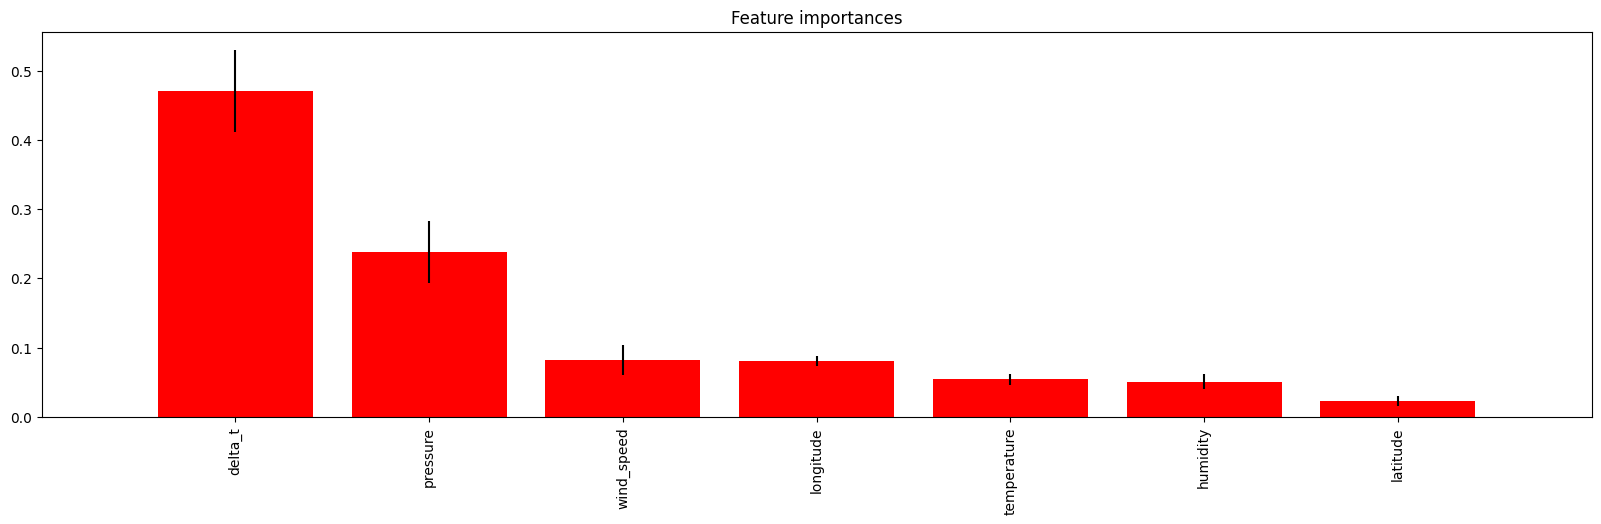

In [10]:
# Plot feature importance
model = models[1]
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
features = columns[training_idx][indices]

# Plot the feature importances of the forest
plt.figure(figsize=(20, 5))
plt.title("Feature importances")
plt.bar(range(X_train[:, training_idx].shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train[:, training_idx].shape[1]), features, rotation=90)
plt.xlim([-1, X_train[:, training_idx].shape[1]])
plt.show()

## Gradient Boosting

In [11]:
model_name = "GradientBoosting"
scale = True
n_estimators = 1000
lr = 0.1

models = []
for fold in trange(n_folds):
    X_train, y_train, X_test, y_test, scaler, columns = load_data(fold, scale=scale)
    
    training_idx = list(range(X_train.shape[1]))

    model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=0, learning_rate=lr)
    model.fit(X_train[:, training_idx], y_train)
    models.append(model)
    y_pred = model.predict(X_test[:, training_idx])
    y_pred_all = np.concatenate([model.estimators_[i][0].predict(X_test[:, training_idx])[:, None] for i in range(n_estimators)], axis=1)
    y_pred_std = np.std(y_pred_all, axis=1)
    if scale:
        [(y_pred, y_test)] = scaler.inverse_transform(y=[y_pred, y_test])
        y_pred_std = y_pred_std * scaler.y_scale
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    msll = -np.mean(norm.logpdf(y_test, loc=y_pred, scale=y_pred_std))
    # assign rmse to RandomForest raw in corresponding fold
    rmse_df.loc[model_name, [f"fold{fold}"]] = rmse
    msll_df.loc[model_name, [f"fold{fold}"]] = msll
# assign mean rmse to RandomForest raw in mean column
rmse_df.loc[model_name, "mean"] = rmse_df.loc[model_name, ["fold0", "fold1", "fold2", "fold3"]].mean()
msll_df.loc[model_name, "mean"] = msll_df.loc[model_name, ["fold0", "fold1", "fold2", "fold3"]].mean()

100%|██████████| 4/4 [01:24<00:00, 21.09s/it]


Tried with less number of estimators but the results were not good or were comparable.

In [12]:
display(rmse_df.style.highlight_min(axis=0, color="green"), msll_df.style.highlight_min(axis=0, color="green"))

,fold0,fold1,fold2,fold3,mean
RandomForest,4.218567,5.160780,3.637691,4.494195,4.377809
GradientBoosting,4.247331,4.858213,3.476085,4.614906,4.299134


,fold0,fold1,fold2,fold3,mean
RandomForest,5.077485,66.609965,2.798552,3.563416,19.512354
GradientBoosting,45.290062,59.364106,42.375248,75.029671,55.514772


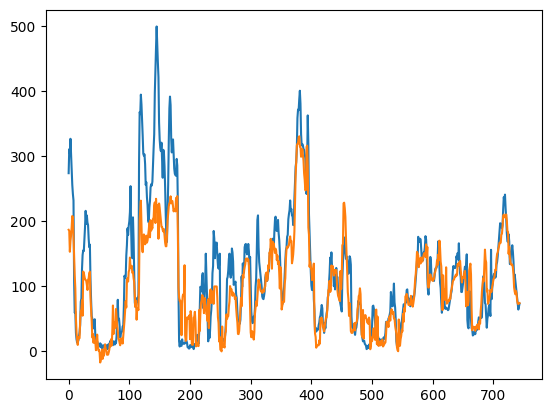

In [11]:
i = 9
plt.plot(y_test[i::10])
plt.plot(y_pred[i::10])

## Adaboost

In [12]:
model_name = "AdaBoost"
scale = True
n_estimators = 100
lr = 0.1

models = []
for fold in trange(n_folds):
    X_train, y_train, X_test, y_test, scaler, columns = load_data(fold, scale=scale)
    
    training_idx = list(range(X_train.shape[1]))

    # base_estimator = RandomForestRegressor(n_estimators=100, random_state=0)
    base_estimator = DecisionTreeRegressor(random_state=0)
    model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=n_estimators, random_state=0, learning_rate=lr)
    model.fit(X_train[:, training_idx], y_train)
    models.append(model)
    y_pred = model.predict(X_test[:, training_idx])
    y_pred_all = np.concatenate([model.estimators_[i].predict(X_test[:, training_idx])[:, None] for i in range(len(model.estimators_))], axis=1)
    y_pred_std = np.std(y_pred_all, axis=1)
    if scale:
        [(y_pred, y_test)] = scaler.inverse_transform(y=[y_pred, y_test])
        y_pred_std = y_pred_std * scaler.y_scale
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    msll = -np.mean(norm.logpdf(y_test, loc=y_pred, scale=y_pred_std))
    # assign rmse to RandomForest raw in corresponding fold
    rmse_df.loc[model_name, [f"fold{fold}"]] = rmse
    msll_df.loc[model_name, [f"fold{fold}"]] = msll
# assign mean rmse to RandomForest raw in mean column
rmse_df.loc[model_name, "mean"] = rmse_df.loc[model_name, ["fold0", "fold1", "fold2"]].mean()
msll_df.loc[model_name, "mean"] = msll_df.loc[model_name, ["fold0", "fold1", "fold2"]].mean()

100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


In [13]:
display(rmse_df.style.highlight_min(axis=0, color="green"), msll_df.style.highlight_min(axis=0, color="green"))

,fold0,fold1,fold2,mean
RandomForest,24.801691,29.698647,25.436687,26.645676
GradientBoosting,26.893900,30.616257,27.241831,28.250661
AdaBoost,26.992208,29.410023,28.504595,28.302274


,fold0,fold1,fold2,mean
RandomForest,4.373172,4.773817,4.626271,4.591087
GradientBoosting,21.612164,22.924467,21.737375,22.091335
AdaBoost,4.408797,4.788488,4.645359,4.614215


## KNN

In [21]:
model_name = "RandomForest"
scale = True
n_estimators = 1000
n_jobs = 48

models = []
preds = []
tests = []
stds = []
for fold in trange(n_folds):
    X_train, y_train, X_test, y_test, scaler, columns = load_data(fold, scale=scale)
    
    training_idx = list(range(X_train.shape[1]))

    model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs, random_state=0)
    model.fit(X_train[:, training_idx], y_train)
    models.append(model)
    y_pred = model.predict(X_test[:, training_idx])
    y_pred_all = np.concatenate([model.estimators_[i].predict(X_test[:, training_idx])[:, None] for i in range(n_estimators)], axis=1)
    y_pred_std = np.std(y_pred_all, axis=1)
    if scale:
        [(y_pred, y_test)] = scaler.inverse_transform(y=[y_pred, y_test])
        y_pred_std = y_pred_std * scaler.y_scale
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    msll = -np.median(norm.logpdf(y_test, loc=y_pred, scale=y_pred_std))
    # assign rmse to RandomForest raw in corresponding fold
    rmse_df.loc[model_name, [f"fold{fold}"]] = rmse
    msll_df.loc[model_name, [f"fold{fold}"]] = msll
    preds.append(y_pred)
    tests.append(y_test)
    stds.append(y_pred_std)
# assign mean rmse to RandomForest raw in mean column
rmse_df.loc[model_name, "mean"] = rmse_df.loc[model_name, ["fold0", "fold1", "fold2"]].mean()
msll_df.loc[model_name, "mean"] = msll_df.loc[model_name, ["fold0", "fold1", "fold2"]].mean()

100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


In [22]:
display(rmse_df.style.highlight_min(axis=0, color="green"), msll_df.style.highlight_min(axis=0, color="green"))

,fold0,fold1,fold2,fold3,mean
RandomForest,4.218567,5.160780,3.637691,4.494195,4.339013
GradientBoosting,4.247331,4.858213,3.476085,4.614906,4.299134
KNN,4.949597,4.441535,4.165256,4.859757,4.604036


,fold0,fold1,fold2,fold3,mean
RandomForest,2.336443,2.773666,2.288902,2.239878,2.466337
GradientBoosting,45.290062,59.364106,42.375248,75.029671,55.514772


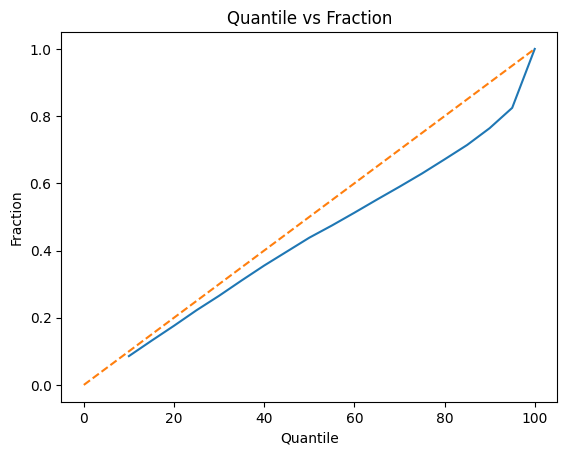

In [19]:
tests = np.concatenate(tests) if isinstance(tests, list) else tests
preds = np.concatenate(preds) if isinstance(preds, list) else preds
stds = np.concatenate(stds) if isinstance(stds, list) else stds

def get_fraction(quantile):
    alpha = get_multiplier(quantile)
    lower = preds - alpha * stds
    upper = preds + alpha * stds
    fraction = np.mean((lower <= tests) & (tests <= upper))
    return fraction

# get quantile by passing the percentage for Gaussian
def get_multiplier(quantile):    
    return norm.ppf(0.5 + 0.5 * (quantile / 100))

quantiles = range(10, 101, 5)
fractions = [get_fraction(quantile) for quantile in quantiles]

plt.plot(quantiles, fractions)
plt.plot([0, 100], [0, 1], linestyle='--')
plt.xlabel("Quantile")
plt.ylabel("Fraction")
plt.title("Quantile vs Fraction")
plt.show()

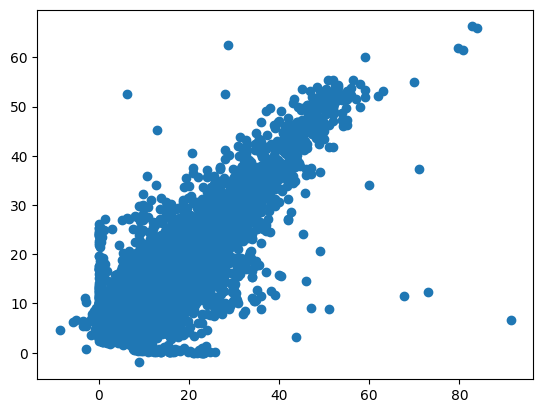

In [20]:
plt.scatter(tests, preds)

In [17]:
rmse_df.to_csv("baseline_rmse.csv", index=True)
msll_df.to_csv("baseline_msll.csv", index=True)

# Post analysis

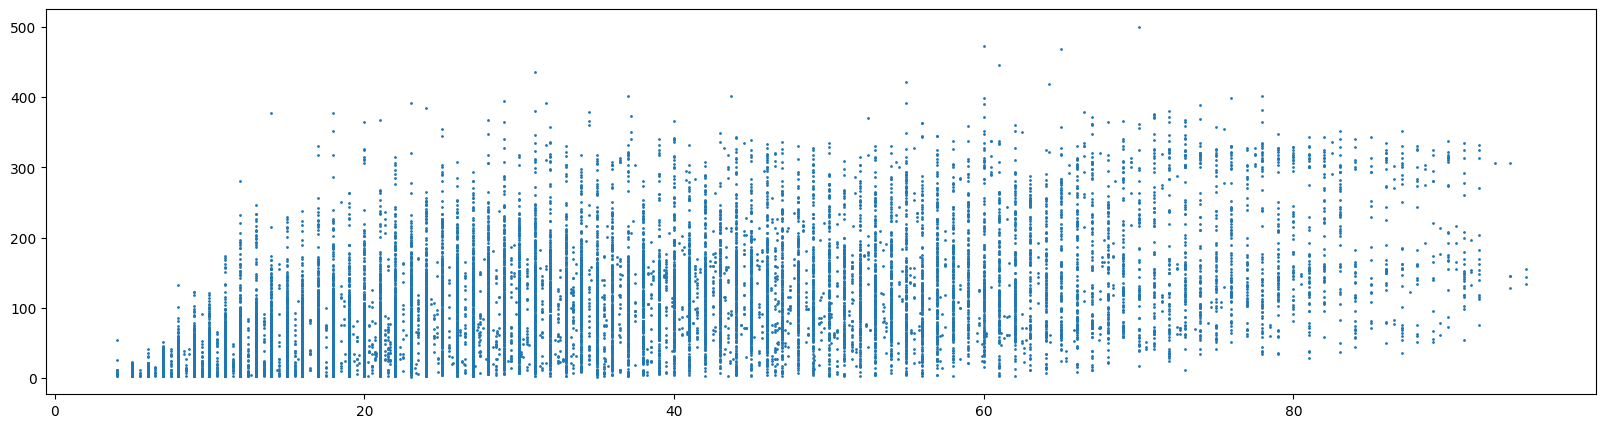

In [18]:
fold = 0
root = "/home/anonymous"
train_data = pd.read_csv(f"{root}/AAAI22/data/time_feature/fold{fold}/train_data_mar_nsgp.csv.gz")
test_data = pd.read_csv(f"{root}/AAAI22/data/time_feature/fold{fold}/test_data_mar_nsgp.csv.gz")

feature = "humidity"
x = np.concatenate([train_data[feature].values, test_data[feature].values])
y = np.concatenate([train_data["PM25_Concentration"].values, test_data["PM25_Concentration"].values])

plt.figure(figsize=(20, 5))
plt.scatter(x, y, s=1)